# 1. Epidemic modelling refresher


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/01-epi-refresher.ipynb)

**Date**: Monday Sept 9, 2024

## LEARNING OUTCOMES
- Remind ourselves about different types of epidemic models
- Understand the basics of discrete-time state transition epidemic models
- Understand a functional approach towards programming discrete-time state transition models

## Types of epidemic models

There are _many_ different types of epidemic models, but a sensible first categorisation is in terms of whether the model is deterministic or stochastic and the time scale and scale (individual to population) on which it is defined.

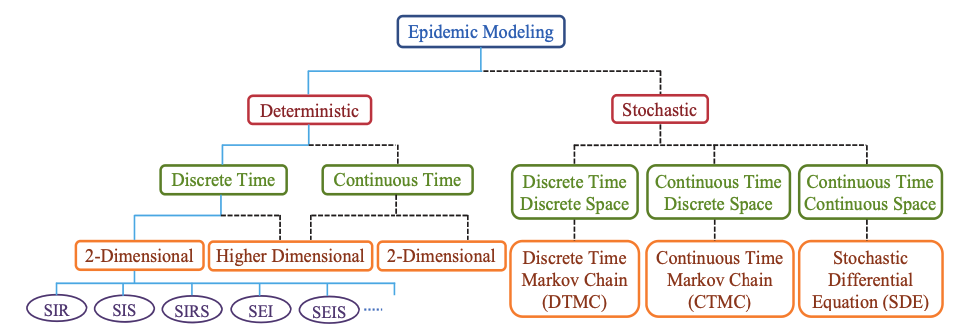

Fig. 1: Classification of different types of epidemic models in terms of stochasticity and time scale (from [[1]](
https://doi.org/10.48550/arXiv.2004.04675))

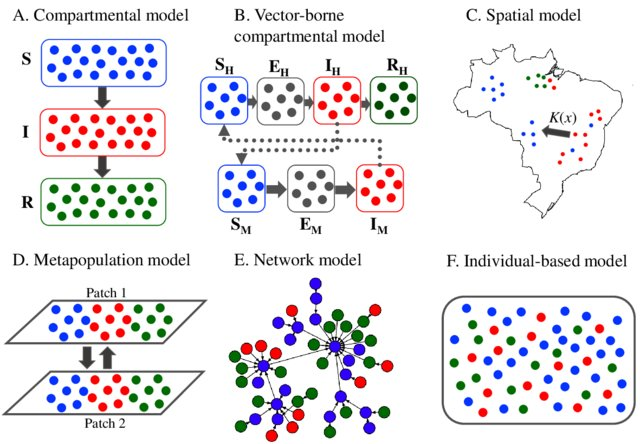

Fig. 2: Classification of epidemic models in terms of population structure (from [[2]](
http://dx.doi.org/10.7717/peerj.4526))

### Deterministic vs stochastic
- **Deterministic models**:
    - no randomness in the evolution of the system (the output of the model is the same every time the model is run)
    - typically formulated as differential or difference equations
    - generally used to model epidemics in the large population limit when it is reasonable to treat the numbers of individuals in each state as continuous and the random fluctuations in these numbers as averaging each other out
- **Stochastic models**:
    - account for randomness in the epidemic process, e.g. in whether or not an individual is infected when they come into contact with an infectious individual (the output is potentially different evry time the model is run)
    - typically formulated as continuous-/discrete-time Markov chains or stochastic differential equations
    - used to model epidemics in both small populations and large populations at an individual-/population-level

### Continuous vs discrete time
- **Continuous-time models**: the system state changes instantaneously when each new event (infection, recovery, etc.) occurs.
- **Discrete-time models**: events are aggregated over a set chunk of time, and we model the change in the system state from one time point to the next in terms of the number of events that have occurred in between.

### Population- to individual-level
- **Population-level models**: track the number of individuals in each model state
- **Metapopulation models**: track the number of individuals in each model state in a number of different subpopulations or groups
- **Individual-level models**: track specific units (individuals/households/farms) across states

In this course we will focus mainly on stochastic epidemic models and discrete time, but we will explore models on different scales from population level to individual level.

## Epidemic modelling theory
- Epidemic models are state transition models, i.e. are composed of a set of epidemiological states and rules for transitioning between them
- In this course, we will focus on discrete-time epidemic models
- We will denote the set of states in the model at time $t$ by $X_t$, and call this the _model state_
- We will denote the rate at which individuals transition between two states in the model $W$ and $Y$ at time $t$ by $\lambda^{WY}_t$, and call this the transition rate for the $W\rightarrow Y$ transition (which in general is a function of the model state at time $t$)

### Epidemic models as state transformers
- Epidemic models can be thought of as state transformers, i.e. given an initial state and set of transition rates the epidemic model tells you how to update/transform the state from one time step to the next
- We will assume that the transitions between the states occur according to a Markov process, i.e. have the _Markov property_ that the future state of the model depends only on its current state and not its previous states. We can write this as:

$$
P(X_{t+\Delta t}=x|X_0=x_0,X_{\Delta t}=x_{\Delta t},\dots,X_t=x_t)=P(X_{t+\Delta t}=x|X_t=x_t)
$$

- We can represent the effect of the transitions in the model on the model state by an _incidence matrix_ (AKA a _stoichiometry matrix_), $B$, whose columns represent the increment in each state in the model (in the rows) when each transition (in the columns) occurs
- The model state can then be updated as:

$$
X_{t+\Delta t}= X_t + B Z_t
$$

where $Z_t$ is a vector containing the number of times that each transition in the model occurs in the short time interval $(t,t+\Delta t]$

### Chain binomial model
- In linear epidemic models without branching (one state going to two or more states) or loops, the number of transitions in a small time interval $\Delta t$ can be modelled as binomial:

$$
Z_t \sim \operatorname{Bin}(X_t,p_t)
$$

where $p_t$ is a vector of probabilities of transitions between consecutive states

In [1]:
import base64
from IPython.display import Image, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))

## A concrete example: the SIR model
In the standard homogeneously mixing SIR model, we have that individuals exist in three mutually exclusive states: S(usuceptible), I(nfectious), and R(emoved), collectively $X_t = (S_t, I_t, R_t)^T$.  

We assume that for a _single individual_, the transition rates between the states at time $t$ are:
\begin{align}
\lambda^{\mathrm{SI}}_t &= \beta I_t/N \\
\lambda^{\mathrm{IR}}_t &= \gamma \\
\end{align}
where $N$ is the total (constant) population size, such that the $S\rightarrow I$ transition depends on the current _prevalence_ of infectious individuals, but infectious individuals transition to being removed at constant rate $\gamma$.


In [2]:
mm("""
flowchart LR
  S-- "#946;"I/N -->I
  I -- "#947;" --> R
""")

The incidence matrix for this model is:

$$
\begin{array}{cc}
&
\begin{array}{ccc} SI & IR & \end{array} \\
B=&
\begin{pmatrix}
-1 & 0\\
1 & -1 \\
0 & 1
\end{pmatrix}
\begin{array}{c} S \\ I \\ R \end{array}
\end{array}
$$

and the transition probabilities for the $S\rightarrow I$ and $I\rightarrow R$ transitions, $p^{SI}_t$ and $p^{IR}_t$, in a time interval $\Delta t$ are given by:

\begin{align*}
p^{SI}_t&=1-e^{-\lambda^{SI}_t\Delta t}=1-e^{\beta I_t/N\,\Delta t} \\
p^{IR}_t&=1-e^{-\lambda^{IR}_t\Delta t}=1-e^{-\gamma\Delta t}
\end{align*}

Given initial conditions, $X_0=(S_0,I_0,R_0)$, the model state can thus be updated as:

\begin{align*}
Z_t&\sim\operatorname{Bin}(X_t,p_t) \\
X_{t+\Delta t}&=X_t+BZ_t
\end{align*}

## Generalisation for models with branches/loops

More general state transition models may have branches where a single state flows into multiple other states and/or loops where individuals can return to states that they were in previously. A more general setup for a Markov state transition model therefore considers transitions between all pairs of states.

For such a setup, we can define a Markov transition rate matrix $Q_t=(q_{ij}(t))$, where $q_{ij}(t)$ denotes the transition rate between states $i$ and $j$ at time $t$. The Markov transition probability matrix, $P_{t,\Delta t}=(p_{ij}(t,\Delta t))$, whose elements are the probabilities of transitioning between states $i$ and $j$ in the time interval $(t,t+\Delta t)$, can be obtained from $Q_t$ as:

$$
P_{t,\Delta t}=e^{Q_t\Delta t}
$$

where $e^A$ is the [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential) (and not a matrix of the exponentiated elements of $Q$).

With this setup, the model state can be updated as:
\begin{align*}
Z_t&\sim\operatorname{VectorMultinomial}(X_t,P_{t,\Delta t}) \\
X_{t+\Delta t}&=\mathbf{1^T} Z_t
\end{align*}
where $\operatorname{VectorMultinomial}$ applies a multinomial distribution element-wise and row-wise respectively to its arguments $X_t$ and $P_{t,\Delta t}$ respectively (i.e. $Z_{ti}=\operatorname{Multinomial}(X_{ti},p_{i\cdot}(t,\Delta t))$)
and $\mathbf{1}$ is a vector of ones of length equal to the number of states in the model).

To implement such a model in code we can either use multinomial draws for the numbers of individuals transitioning out of each state or nested binomial draws (where we first draw the total number transitioning out of a state according to the total transition rate out of that state, and then from that number draw the number transitioning to the first connected state, and so on).

## Example: the SVIRS model
We can extend the SIR model above, by adding a state for vaccinated individuals and loss of immunity. We assume that there is competition for susceptibles between the $SI$ and $SV$ transitions, and that after a period of time an individual's immunity wanes such that they transition from R back to S.

In [3]:
mm("""
flowchart LR
  S -- "#955;"<sub>t</sub><sup>SI</sup>--> V
  S -- "#955;"<sub>t</sub><sup>SV</sup> --> I
  V -- "#955;"<sub>t</sub><sup>VI</sup>--> I
  I -- "#955;"<sub>t</sub><sup>IR</sup> --> R
  R -- "#955;"<sub>t</sub><sup>RS</sup>--> S
""")

The transition matrix for this model is:
$$
Q = \begin{pmatrix}
-(\lambda^{SI}_t+\lambda^{SV}_t) & \lambda^{SV}_t & \lambda^{SI}_t & 0 \\
0 & -\lambda^{VI}_t & \lambda^{VI}_t & 0 \\
0 & 0 & -\lambda^{IR}_t & \lambda^{IR}_t \\
\lambda^{RS}_t & 0 & 0 & -\lambda^{RS}_t
\end{pmatrix}
$$

### Exercise 1
Write down the incidence matrix for this model:

### Solution

$$
\begin{array}{cc}
&
\begin{array}{ccccc} SV & SI & VI & IR &\\
\end{array}
\\
B= &
\left(
\begin{array}{cccc}
-1 & -1 & 0 & 0 \\
1 & 0 & -1 & 0 \\
0 & 1 & 1 & -1 \\
0 & 0 & 0 & 1
\end{array}
\right)
\begin{array}{c}S \\ V \\ I \\ R \end{array}
\end{array}
$$

## Simulating the SIR model in discrete time

## Imperative programming approach

### Set initial values

In [4]:
# initial values
time_delta = 1
initial_pop = [99,1,0]
parameters0 = [0.01, 0.05]

### Single iteration

### Exercise 2
Write out the simulation algorithm for one iteration

```
def sir_propagate(state, parameters, time_delta):
    # Unpack parameters

    # Step 1: compute transition rates

    # Step 2: convert event rates to probabilities

    # Step 3: simulate one step forward

    # Step 4: update state of the system
```

### Solution

In [5]:
# simulate SIR event
def sir_propagate(state, parameters, time_delta):

    # epidemic constants
    beta, gamma = parameters
    num_susceptibles, num_infected, num_removed = state

    num_pop = np.sum(state)

    # Step 1: compute transition rates
    SI_rate = beta*(num_susceptibles * num_infected)/num_pop
    IR_rate = gamma

    # Step 2: convert event rates to probabilities
    i_rate = 1 - np.exp(- SI_rate * time_delta)
    r_rate = 1 - np.exp(- IR_rate * time_delta)

    # Step 3: simulate one step forward
    num_new_infections = np.random.binomial(num_susceptibles, i_rate)
    num_new_removals = np.random.binomial(num_infected, r_rate)

    # Step 4: update state of the system
    return [num_susceptibles - num_new_infections,
            num_infected + num_new_infections - num_new_removals,
            num_removed + num_new_removals]

In [6]:
# single iteration/forward step
sir_propagate(initial_pop, parameters0, time_delta)

[99, 1, 0]

### Simulate path

Simulate 100 steps

In [7]:
# simulate full path
def simulate(initial_state, num_steps):
    # counters
    ii = 0
    S = np.zeros(num_steps)
    I = np.zeros(num_steps)
    R = np.zeros(num_steps)

    # unpack the state
    S[0], I[0], R[0] = initial_state
    state = initial_state

    while ii < num_steps:
        state = sir_propagate(state, parameters0, time_delta)

        S[ii], I[ii], R[ii] = state

        ii += 1

    return {'Time': np.cumsum(np.repeat(time_delta, num_steps)),
            'Susceptible': S,
            'Infected': I,
            'Removed': R}

In [8]:
sample_epi = simulate(initial_pop, 100)

In [9]:
pd.DataFrame(sample_epi)

,Time,Susceptible,Infected,Removed
0,1,97.0,3.0,0.0
1,2,96.0,4.0,0.0
2,3,93.0,7.0,0.0
3,4,86.0,13.0,1.0
4,5,77.0,22.0,1.0
...,...,...,...,...
95,96,3.0,1.0,96.0
96,97,3.0,1.0,96.0
97,98,3.0,1.0,96.0
98,99,3.0,1.0,96.0


### Plot the curves

Text(0.5, 1.0, 'Single path simulation')

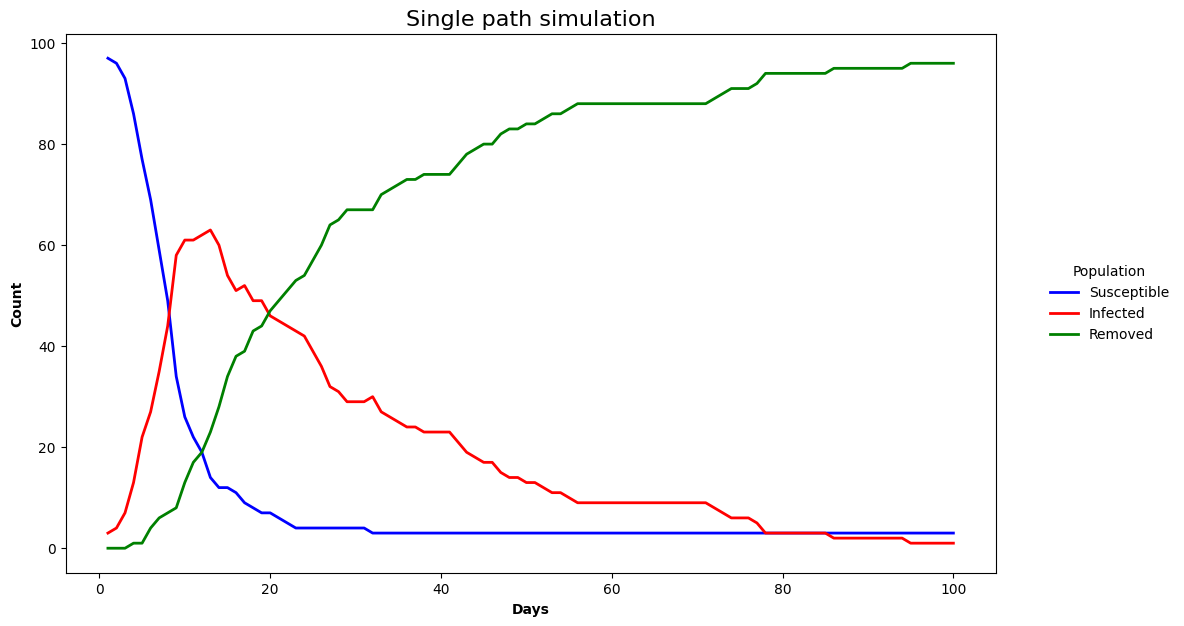

In [10]:
plt.figure(figsize=(12, 7))

S_line = plt.plot("Time","Susceptible", data=sample_epi, color="b", linewidth=2)
I_line = plt.plot("Time","Infected", data=sample_epi, color="r", linewidth=2)
R_line = plt.plot("Time","Removed", data=sample_epi, color="g", linewidth=2)

plt.xlabel("Days",fontweight="bold")
plt.ylabel("Count",fontweight="bold")

legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.2,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

# Add labels and title
plt.xlabel('Days', fontweight="bold")  # Add x-axis label with font styling
plt.ylabel('Count', fontweight="bold")  # Add y-axis label with font styling
plt.title('Single path simulation', fontsize=16)  # Add plot title with font size

### Simulating multiple paths

In [11]:
num_steps = 100
num_paths = 200
epi_realizations = []

In [12]:
for jj in range(0,num_paths):
    epi_realizations.append(simulate(initial_pop, num_steps))

In [13]:
# plot them

# Define labels outside the loop
susceptible_label = "Susceptible"
infected_label = "Infected"
removed_label = "Removed"

Text(0.5, 1.0, 'Multiple path simulations')

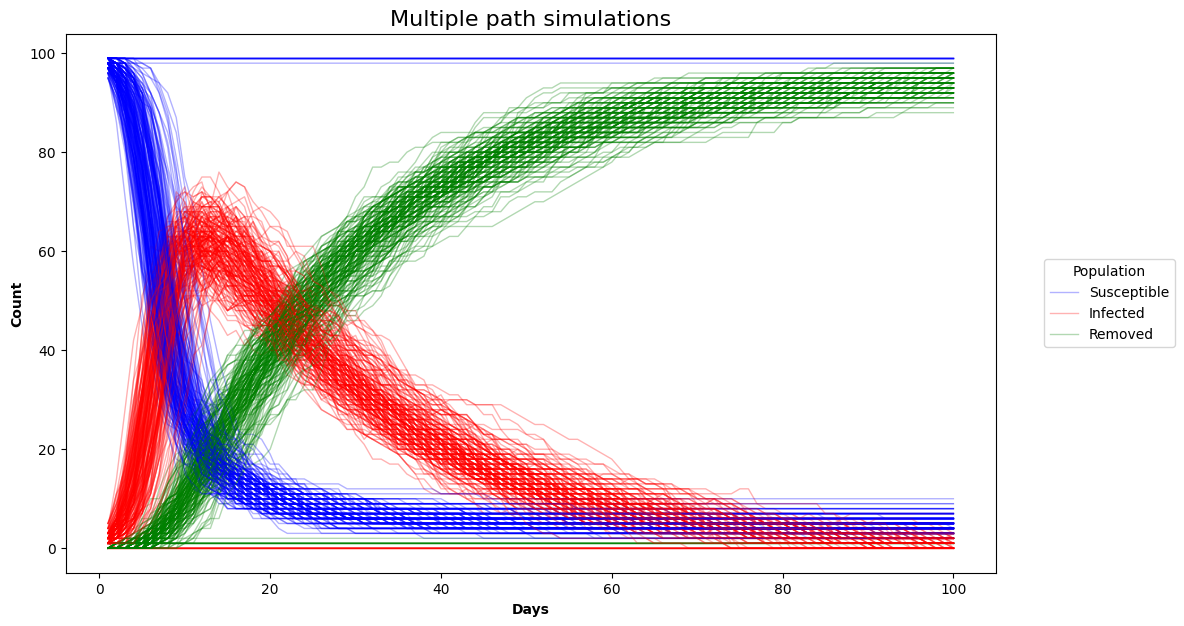

In [14]:
plt.figure(figsize=(12, 7))

for jj in range(0, num_paths):
    # Plot the lines without labels
    S_line, = plt.plot("Time", "Susceptible", data=epi_realizations[jj], label=susceptible_label, color="b", linewidth=1, alpha=0.3)
    I_line, = plt.plot("Time", "Infected", data=epi_realizations[jj], label=infected_label, color="r", linewidth=1, alpha=0.3)
    R_line, = plt.plot("Time", "Removed", data=epi_realizations[jj], label=removed_label, color="g", linewidth=1, alpha=0.3)

# Create an empty list to store plot handles
plot_handles = [S_line, I_line, R_line]

# Generate legend using handles and labels
plt.legend(handles = plot_handles,
           labels=[susceptible_label,
                   infected_label,
                   removed_label],
           title="Population", loc=5, bbox_to_anchor=(1.2, 0.5))

frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

# Add labels and title
plt.xlabel('Days', fontweight="bold")  # Add x-axis label with font styling
plt.ylabel('Count', fontweight="bold")  # Add y-axis label with font styling
plt.title('Multiple path simulations', fontsize=16)  # Add plot title with font size

## Functional programming approach

We want to restructure the code above in a more functional way. While Python is not a fully functional language, we can still pass functions around to create programmes that are a combination of several composable instructions. This behaves similarly to the pipe operation in R.

The benefit of doing this is that it isolates steps in the computation which means we can separate the mathematical/model aspects from the code logic. It results in more robust code that is easier to read and manage.

The formulation of discrete-time stochastic compartmental epidemic models we introduced above allows us to decompose the simulation of such models into their different parts:
- transition rates
- incidence matrix
- initial state
- state update

### Exercise 3
Try to code the discrete-time SIR model by breaking the problem down into the above components. Use closures to define functions that return functions for evaluating the transition rates and propagating the model state forward by one time step.

```
# transition rate function closure
def transition_rates(parameters):
    # unpack parameters
    
    # return function that evaluates transition rates for given parameter values
    def evaluate_transition_rates(state):

    return evaluate_transition_rates
```

```
# incidence matrix
incidence_matrix = np.array(
    
)
```

```
# epidemic propagation function closure
def propagate_epidemic(time_delta, transition_rate_fn):

    def single_iteration(state):
        # compute constants for the iteration

        # compute the transition rates for the system

        # convert event rates to probabilities

        # simulate one step forward

        # output the changes in the system

    return single_iteration
```



```
# state update function
def update_state(state, incidence_matrix, new_events):
    # combine current state with incidence matrix and number of events in each
    # state to compute new state
```


```
# plot output
```

### Solution

In [17]:
# decomposing the problem

# transition rate function closure
def transition_rates(parameters):
    # unpack parameters
    beta, gamma = parameters

    # return function that evaluates transition rates for given parameter values
    def evaluate_transition_rates(state):
        num_susceptibles = state[0]
        num_infected = state[1]
        num_pop = np.sum(state)

        SI_rate = beta*(num_susceptibles * num_infected)/num_pop
        IR_rate = gamma

        return [SI_rate, IR_rate]

    return evaluate_transition_rates


In [18]:
# incidence matrix
incidence_matrix = np.array(
    [#SI #IR
     [-1, 0], #S
     [1, -1], #I
     [0, 1]]  #R
)

In [19]:
# epidemic propagation function closure
def propagate_epidemic(time_delta, transition_rate_fn):

    def single_iteration(state):
        # compute constants for the iteration
        num_susceptibles = state[0]
        num_infected = state[1]
        num_pop = np.sum(state)

        # compute the transition rates for the system
        SI_rate, IR_rate = transition_rate_fn(state)

        # convert event rates to probabilities
        i_rate = 1 - np.exp(- SI_rate * time_delta)
        r_rate = 1 - np.exp(- IR_rate * time_delta)

        # simulate one step forward
        num_new_infections = np.random.binomial(num_susceptibles, i_rate)
        num_new_removals = np.random.binomial(num_infected, r_rate)

        # output the changes in the system
        return [num_new_infections, num_new_removals]

    return single_iteration


In [20]:
# state update function
def update_state(state, incidence_matrix, new_events):
    # combine current state with incidence matrix and number of events in each
    # state to compute new state
    return state + incidence_matrix.dot(new_events)

In [21]:
# initialize functions
transition_rate_fn = transition_rates(parameters0)

In [22]:
propagate_epidemic_fn = propagate_epidemic(time_delta, transition_rate_fn)

In [23]:
# lets examine what came out
transition_rate_fn

<function __main__.transition_rates.<locals>.evaluate_transition_rates(state)>

In [24]:
transition_rate_fn(initial_pop)

[0.009899999999999999, 0.05]

In [25]:
propagate_epidemic_fn

<function __main__.propagate_epidemic.<locals>.single_iteration(state)>

In [26]:
propagate_epidemic_fn(initial_pop)

[0, 0]

In [27]:
# function to run the model
def simulate_epidemic_path(num_steps, incidence_matrix, initial_state, propagate_epidemic_fn, update_state, time_delta):
    state = [initial_state]
    t = [0]

    for ii in range(0, num_steps):
        events = propagate_epidemic_fn(state[ii])

        new_state = update_state(state[ii], incidence_matrix, events)

        state.append(new_state)
        t.append((ii+1)*time_delta)

    state_result = np.stack(state, axis=0)
    t_result = np.stack(t, axis=0)

    return {'t': t_result,
            'state': state_result}

In [28]:
sir_sim = simulate_epidemic_path(num_steps, incidence_matrix, initial_pop, propagate_epidemic_fn, update_state, time_delta)

In [35]:
# plot output
def plot_epicurve(epidemic_path):
    plt.figure(figsize=(12, 7))

    if not isinstance(epidemic_path, list):
        epidemic_path = [epidemic_path]

    for jj in range(len(epidemic_path)):
        # Plot the lines without labels
        S_line, = plt.plot(epidemic_path[jj]['t'], epidemic_path[jj]['state'][:,0], color="b", linewidth=1, alpha=0.3)
        I_line, = plt.plot(epidemic_path[jj]['t'], epidemic_path[jj]['state'][:,1], color="r", linewidth=1, alpha=0.3)
        R_line, = plt.plot(epidemic_path[jj]['t'], epidemic_path[jj]['state'][:,2], color="g", linewidth=1, alpha=0.3)

    # Create an empty list to store plot handles
    plot_handles = [S_line, I_line, R_line]

    # Generate legend using handles and labels
    plt.legend(handles = plot_handles,
           labels=[susceptible_label,
                   infected_label,
                   removed_label],
           title="Population", loc=5, bbox_to_anchor=(1.2, 0.5))

    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_linewidth(0)

    # Add labels and title
    plt.xlabel('Days', fontweight="bold")  # Add x-axis label with font styling
    plt.ylabel('Count', fontweight="bold")  # Add y-axis label with font styling

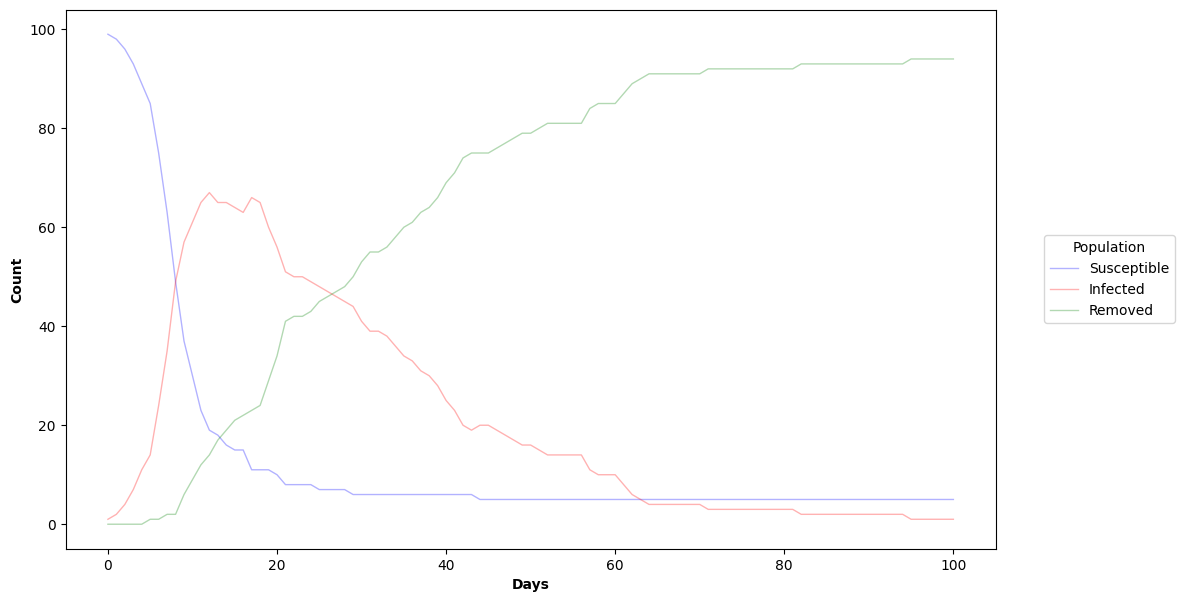

In [30]:
plot_epicurve(sir_sim)

In [32]:
functional_epi_realizations = []
type(functional_epi_realizations)

for jj in range(0,num_paths):
    functional_epi_realizations.append(simulate_epidemic_path(num_steps, incidence_matrix, initial_pop, propagate_epidemic_fn, update_state, time_delta))

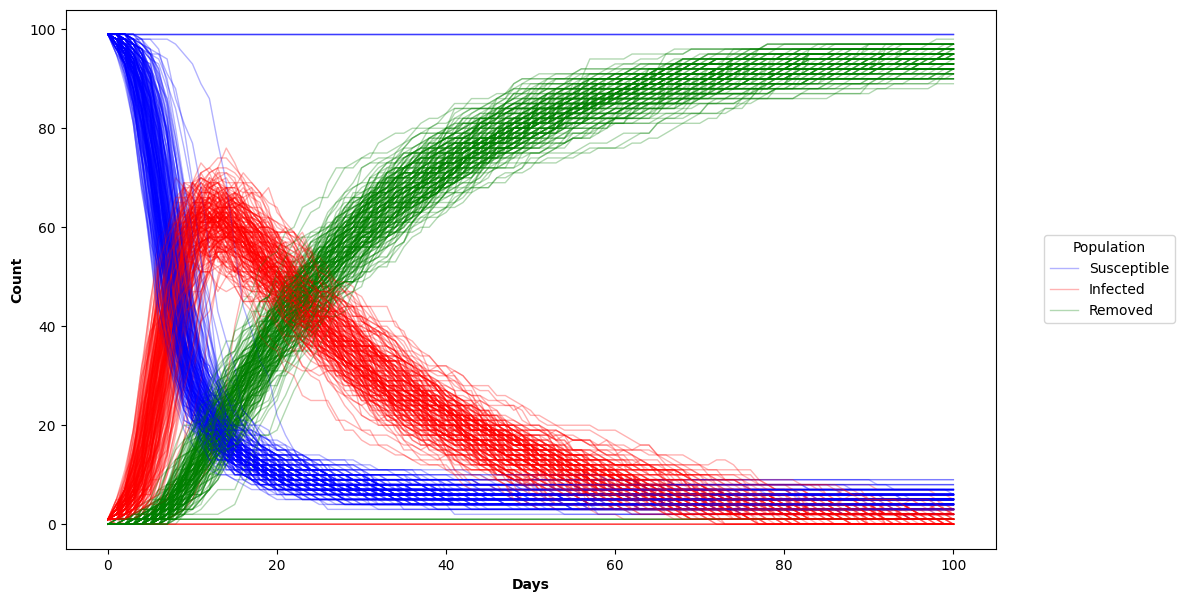

In [33]:
plot_epicurve(functional_epi_realizations)